## Movie reviews: binary classification
Il **Word embedding** è un modello che ci permette di generare una serie di vettori (embedding vectors) ognuno dei quali quantifica una caratteristica delle parole. Classificheremo le recensioni  positive o negative usando il Word Embedding

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/nlp/imdb.jpg" width="1100">


In [18]:
import numpy as np
from tensorflow.keras.datasets import imdb 

num_words = 10000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

print("Numero di esempi nel train set: %d" % len(X_train))
print("Numero di esempi nel test set: %d" % len(X_test))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


Numero di esempi nel train set: 25000
Numero di esempi nel test set: 25000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Ogni riga della lista con le features corrisponde ad una frase, ogni colonna contiene l'indice di una parola all'interno del vocabolario dell'intero corpus di testo. Il vettore con il target contiene un unico valore che può essere 0 per una recensione negativa o 1 per una recensione positiva.<br> 
Definiamo una funzione che ci permette di ricostruire la frase partendo dagli indici, per farlo abbiamo bisogno del vocabolario che mappa le parole agli indici, possiamo ottenerlo con il metodo *.get_word_index()*.
<br>
**NOTA BENE**
<br>
Gli indici delle parole hanno un'offset di 3, quindi per ottenere l'indice corretto per il vocabolario dovremo sottrarre 3 all'indice della parola contenuto nella frase.

In [19]:
word_index = imdb.get_word_index()
index_word = dict([(value, key) for (key, value) in word_index.items()])

def vec_to_text(x):
  text = [index_word.get(i-3,'?') for i in x]
  return " ".join(text)
  
vec_to_text(X_test[0])

"? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss"

Ovviamente le recensioni avranno lunghezza differente, calcoliamo la lunghezza della più lunga e della più corta.

In [20]:
longest_review = max(X_train,key=len)
shortest_review = min(X_train,key=len)

print("La review più lunga ha %d parole" % len(longest_review))
print("La review più corta ha %d parole" % len(shortest_review))

La review più lunga ha 2494 parole
La review più corta ha 11 parole


Per rendere le features un buon input per il nostro modello dobbiamo fare in modo che ogni frase abbia la stessa lunghezza, per farlo possiamo usare la funzione *pad_sequences(text)* di keras, che riduce tutte le frasi ad una lunghezza prefissata troncando quelle troppo lunghe e aggiungendo degli zeri a quelle troppo brevi. Usiamo una lunghezza comune di 50 parole.

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/nlp/padded.png" width="600">



In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 50

X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

X_train.shape

(25000, 50)

## Creiamo il modello
Possiamo utilizzare l'embedding come se fosse uno strato della nostra rete neurale che verrà anch'esso ottimizzato durante la fase di addestramento. Creiamo la rete aggiungendo al primo strato uno strato di embedding, dopodichè aggiungiamo un'altro strato che utilizza la classe Flatten() di keras per convertire la matrice che contiene la rappresentazione vettoriale di una frase in un vettore, unendo tutte le righe una dietro l'altra. Infine aggiungiamo uno strato di output per eseguire la classificazione binaria.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,LSTM
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()

model.add(Embedding(num_words, 50, input_length=maxlen))
model.add(SimpleRNN(32))
#model.add(LSTM(16))
#model.add(LSTM(16,dropout=0.5,recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2656      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 502,689
Trainable params: 502,689
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    batch_size=512, 
                    validation_split=0.2, 
                    epochs=8
                    )

Epoch 1/8
40/40 [==============================] - 3s 45ms/step - loss: 0.6455 - accuracy: 0.6126 - val_loss: 0.6270 - val_accuracy: 0.6964
Epoch 2/8
40/40 [==============================] - 2s 40ms/step - loss: 0.4360 - accuracy: 0.8127 - val_loss: 0.4480 - val_accuracy: 0.7894
Epoch 3/8
40/40 [==============================] - 2s 41ms/step - loss: 0.3405 - accuracy: 0.8646 - val_loss: 0.4848 - val_accuracy: 0.7732
Epoch 4/8
40/40 [==============================] - 2s 40ms/step - loss: 0.2788 - accuracy: 0.8907 - val_loss: 0.4670 - val_accuracy: 0.7788
Epoch 5/8
40/40 [==============================] - 2s 40ms/step - loss: 0.2299 - accuracy: 0.9159 - val_loss: 0.4802 - val_accuracy: 0.7874
Epoch 6/8
40/40 [==============================] - 2s 41ms/step - loss: 0.1694 - accuracy: 0.9447 - val_loss: 0.5085 - val_accuracy: 0.7740
Epoch 7/8
40/40 [==============================] - 2s 41ms/step - loss: 0.1274 - accuracy: 0.9628 - val_loss: 0.5151 - val_accuracy: 0.7854
Epoch 8/8
40/40 [===

In [26]:
model.evaluate(X_test, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.6386 - accuracy: 0.7754


[0.6386204361915588, 0.775439977645874]

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

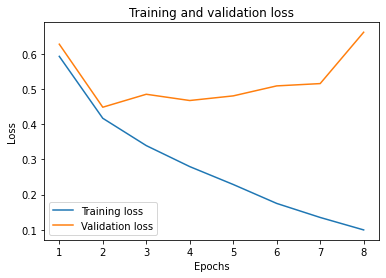

In [28]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

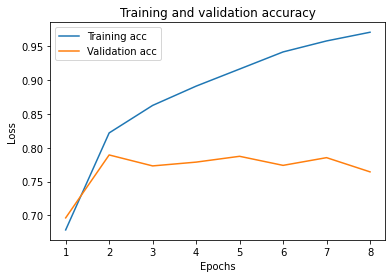

In [29]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [30]:
model.save('model1.h5') 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


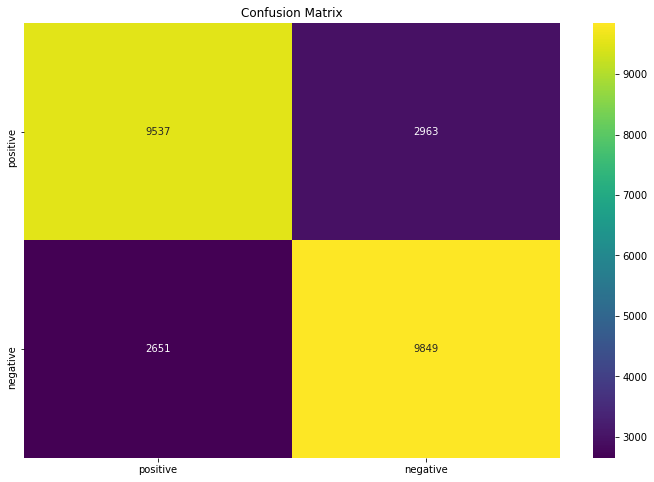

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title('Confusion Matrix')
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['positive','negative']
sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt=".0f",cmap='viridis');


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     12500
           1       0.77      0.79      0.78     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000



In [37]:
# input = np.where((load_model.predict(text_vectorized))> 0.5, 1, 0)
# input

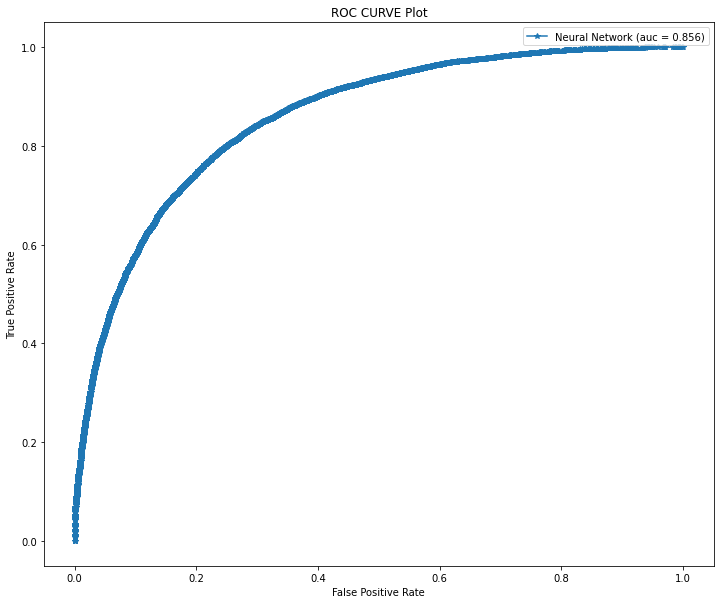

In [38]:
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_test).ravel() #flatten array

plt.figure(figsize=(12,10))

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='*', label='Neural Network (auc = %0.3f)' % auc_keras);

# Title
plt.title('ROC CURVE Plot')

#Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Legend
plt.legend();

## Otteniamo gli embedding
Se volessimo conoscere gli embedding che il modello genera per una determinata frase possiamo farlo creando un nuovo modello che da in output l'output dell'embedding che abbiamo addestrato. Keras ci da la possibilità di accedere ai singoli strati di un modello utilizzato l'attributo *.layers*

In [39]:
model.layers[0]

In [40]:
from tensorflow.keras.models import Model
embedding_model = Model(inputs=model.input, outputs=model.layers[0].output)

Utilizzando il metodo *.predict(x)* otterremo una matrice con la rappresentazione vettoriale di ogni parola della frase.

In [41]:
x = np.array([X_test[0]])

y_pred = embedding_model.predict(x)
y_pred

array([[[ 0.01988319,  0.0466108 ,  0.08107255, ..., -0.02450549,
          0.0458346 ,  0.01546857],
        [-0.00102032, -0.03292919,  0.02099645, ...,  0.00765929,
         -0.03992857,  0.03173036],
        [ 0.03474915, -0.01379289, -0.00820714, ..., -0.01586987,
          0.00029419, -0.00794571],
        ...,
        [-0.03925427,  0.02195229,  0.00338674, ..., -0.01762006,
          0.00471294, -0.00517238],
        [ 0.03010937,  0.02994182, -0.01025713, ...,  0.01138887,
          0.04108507,  0.0647637 ],
        [-0.0685259 ,  0.00704097,  0.01550728, ...,  0.02535583,
         -0.0275325 ,  0.01306555]]], dtype=float32)

In [42]:
len(y_pred[0])

50